In [1]:
# importing general necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
# data preparation libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
# model that is fitted on the data
from sklearn.ensemble import RandomForestRegressor

In [2]:
# importing the dataset and making some adjustments so it works with the model and the time series split
df = pd.read_csv("../data/combined_dataset_temp.csv").drop(columns=["Unnamed: 0", "GAUL", "M49"]).sort_values("Year")
df["Casualties"] = df["Casualties"].fillna(0)
df["Undernourishment (%)"] = df["Undernourishment (%)"].replace({"<2.5": 0})
df["Undernourishment (%)"] = pd.to_numeric(df["Undernourishment (%)"])
df = df.dropna()

In [3]:
# Creating training and test data, but not randomly splitting (roughly two years get excluded) and scaling
sc_x = StandardScaler()
sc_y = StandardScaler()

df_model = df.drop(columns=["Area", "Year", "GDP (MUSD)", "Food Prod. Index"])

df_model_x = sc_x.fit_transform(df_model[["GNI (MUSD)", "Temperature", "Precipitation", "NDVI", "Casualties"]])
df_model_x = pd.DataFrame(df_model_x, columns=["GNI (MUSD)", "Temperature", "Precipitation", "NDVI", "Casualties"])

df_model_y = sc_y.fit_transform(df_model["Undernourishment (%)"].array.reshape(-1, 1))
df_model_y = pd.DataFrame(df_model_y, columns=["Undernourishment (%)"])

y_train = df_model_y["Undernourishment (%)"].iloc[:-310]
X_train = df_model_x.iloc[:-310]

y_test = df_model_y["Undernourishment (%)"].iloc[-310:]
X_test = df_model_x.iloc[-310:]

In [4]:
# model performance on training data
tscv = TimeSeriesSplit(n_splits=5, test_size=310)
model = RandomForestRegressor()
scores = cross_val_score(model, X_train, y_train, cv=tscv)

print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.79 accuracy with a standard deviation of 0.01


In [5]:
# Compare with normal split, to see how much trend there actually is in the data
model = RandomForestRegressor()
scores = cross_val_score(model, X_train, y_train, cv=5)

print("%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std()))

0.82 accuracy with a standard deviation of 0.03


In [6]:
# using the best model to predict the test data, after fitting it on the training data
model = RandomForestRegressor()
model.fit(X_train, y_train)

print("model score on training data:",model.score(X_train, y_train))
print("model score on test data:",model.score(X_test, y_test))

model score on training data: 0.9828497155551393
model score on test data: 0.6993240733355311


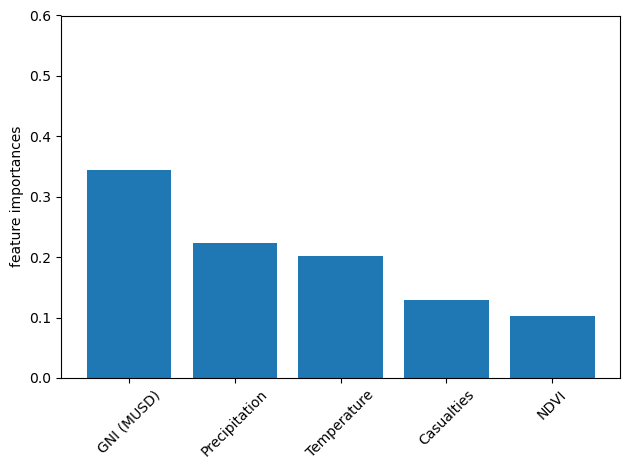

In [7]:
# Looking at the influence of the different features
feature_names = [x for x in X_train.columns]
importances = model.feature_importances_
sorted_lists = sorted(zip(importances, feature_names), reverse=True)
importances, feature_names = [x[0] for x in sorted_lists], \
    [x[1] for x in sorted_lists]

plt.figure()
plt.bar(feature_names, importances)
plt.xticks(rotation=45)
plt.ylabel("feature importances")
plt.ylim(0,0.6)
plt.tight_layout()
plt.show()

In [8]:
# making predictions and saving the results
res = pd.DataFrame()
res["Pred. Undernourishment"] = model.predict(X_test)
res = sc_y.inverse_transform(res)

df_result = df[["Area", "Year", "Undernourishment (%)"]].iloc[-310:]
df_result["Pred. Undernourishment"] = res
df_result = df_result.sort_values("Area").rename(columns={"Undernourishment (%)": "Real Undernourishment"})
df_result.to_csv("../data/present_pred_result.csv")

<Figure size 640x480 with 0 Axes>

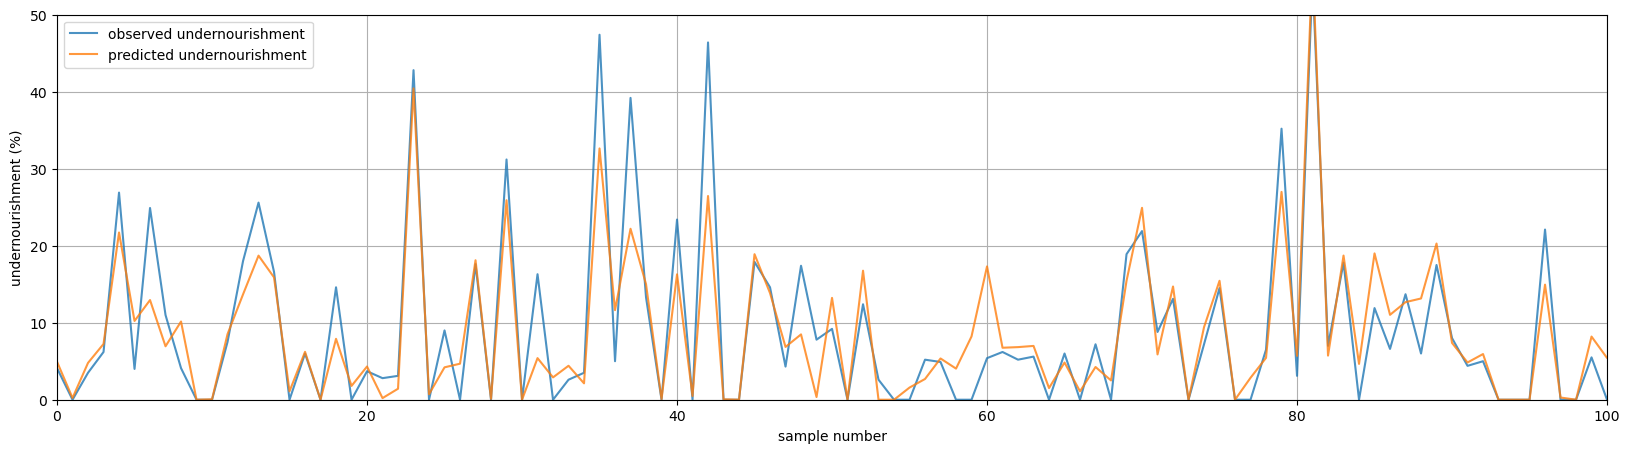

In [9]:
# plotting actual vs predicted undernourishment
plt.figure()
plt.figure(figsize=(20, 5))
plt.plot(df_model["Undernourishment (%)"].iloc[-310:].to_numpy(), alpha=0.8, label="observed undernourishment")
plt.plot(res,alpha=0.8, label="predicted undernourishment")
plt.xlabel("sample number")
plt.ylabel("undernourishment (%)")
plt.legend(loc="upper left")
plt.xlim(0,100)
plt.ylim(0,50)
plt.grid()
plt.show()